In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import tensorflow_datasets as tfds
import numpy as np
import gc

# 1. Load Data
ds_train_raw, ds_test_raw = tfds.load("oxford_iiit_pet", split=["train", "test"], as_supervised=True)
info = tfds.builder("oxford_iiit_pet").info
label_names = info.features["label"].names

# 2. Filter for Dogs only
cat_breeds = {"Abyssinian","Bengal","Birman","Bombay","British_Shorthair","Egyptian_Mau",
              "Maine_Coon","Persian","Ragdoll","Russian_Blue","Siamese","Sphynx"}
dog_label_ids = [i for i, n in enumerate(label_names) if n not in cat_breeds]
num_classes = len(dog_label_ids)
dog_names = [label_names[i] for i in dog_label_ids]

# 3. Mapping & Preprocessing
IMG_SIZE, BATCH_SIZE = 224, 16
keys = tf.constant(dog_label_ids, tf.int64)
vals = tf.constant(list(range(num_classes)), tf.int64)
table = tf.lookup.StaticHashTable(tf.lookup.KeyValueTensorInitializer(keys, vals), -1)

def prep(img, label, augment=False):
    img = tf.image.resize(img, (IMG_SIZE, IMG_SIZE))
    img = tf.cast(img, tf.float32) / 255.0
    if augment:
        img = tf.image.random_flip_left_right(img)
    return img, table.lookup(label)

# 4. Create Datasets
ds_all = ds_train_raw.filter(lambda img, lbl: tf.reduce_any(tf.equal(lbl, tf.constant(dog_label_ids, tf.int64))))
ds_val = ds_all.take(800).map(lambda x, y: prep(x, y)).batch(BATCH_SIZE).prefetch(2)
ds_train = ds_all.skip(800).map(lambda x, y: prep(x, y, True)).batch(BATCH_SIZE).prefetch(2)
ds_test = ds_test_raw.filter(lambda img, lbl: tf.reduce_any(tf.equal(lbl, tf.constant(dog_label_ids, tf.int64)))).map(lambda x, y: prep(x, y)).batch(BATCH_SIZE).prefetch(2)

print(f"Setup complete. Dog classes: {num_classes}")

Setup complete. Dog classes: 25


In [ ]:
def build_model(name, num_classes):
    inputs = keras.Input(shape=(IMG_SIZE, IMG_SIZE, 3))
    if name == "resnet50":
        base = keras.applications.ResNet50(include_top=False, weights="imagenet", input_tensor=inputs)
    elif name == "efficientnetb0":
        base = keras.applications.EfficientNetB0(include_top=False, weights="imagenet", input_tensor=inputs)
    else:
        base = keras.applications.MobileNetV2(include_top=False, weights="imagenet", input_tensor=inputs)

    base.trainable = False
    x = layers.GlobalAveragePooling2D()(base.output)
    x = layers.Dropout(0.3)(x)
    outputs = layers.Dense(num_classes, activation="softmax")(x)
    model = keras.Model(inputs, outputs)
    model.compile(optimizer=keras.optimizers.Adam(1e-3), loss="sparse_categorical_crossentropy", metrics=["acc"])
    return model, base

def train_model(model, base, name):
    # Stage 1
    print(f"Training {name} - Stage 1")
    model.fit(ds_train, validation_data=ds_val, epochs=5)

    # Stage 2 - Fine Tuning
    print(f"Training {name} - Stage 2")
    base.trainable = True
    # Freeze bottom 70% and all BatchNormalization layers (Stops the crashing)
    for layer in base.layers[:int(len(base.layers) * 0.7)]: layer.trainable = False
    for layer in base.layers:
        if isinstance(layer, layers.BatchNormalization): layer.trainable = False

    model.compile(optimizer=keras.optimizers.Adam(1e-5), loss="sparse_categorical_crossentropy", metrics=["acc"])
    model.fit(ds_train, validation_data=ds_val, epochs=5)
    model.save(f"{name}_dogs.keras")

In [ ]:
for arch in ["resnet50", "efficientnetb0", "mobilenetv2"]:
    m, b = build_model(arch, num_classes)
    train_model(m, b, arch)
    del m, b
    keras.backend.clear_session()
    gc.collect()
print("ALL MODELS TRAINED AND SAVED!")

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 5s 0us/step
Training resnet50 - Stage 1
Epoch 1/5
    106/Unknown 27s 106ms/step - acc: 0.0445 - loss: 3.4867

/usr/local/lib/python3.12/dist-packages/keras/src/trainers/epoch_iterator.py:160: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


106/106 ━━━━━━━━━━━━━━━━━━━━ 33s 171ms/step - acc: 0.0445 - loss: 3.4861 - val_acc: 0.0350 - val_loss: 3.2437
Epoch 2/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 22s 188ms/step - acc: 0.0403 - loss: 3.3521 - val_acc: 0.0350 - val_loss: 3.2217
Epoch 3/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 110ms/step - acc: 0.0506 - loss: 3.2871 - val_acc: 0.0375 - val_loss: 3.1978
Epoch 4/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 94ms/step - acc: 0.0504 - loss: 3.2526 - val_acc: 0.0400 - val_loss: 3.1896
Epoch 5/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step - acc: 0.0710 - loss: 3.2047 - val_acc: 0.0475 - val_loss: 3.1736
Training resnet50 - Stage 2
Epoch 1/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 43s 220ms/step - acc: 0.0857 - loss: 3.1564 - val_acc: 0.0887 - val_loss: 3.1000
Epoch 2/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 19s 163ms/step - acc: 0.0821 - loss: 3.0893 - val_acc: 0.0913 - val_loss: 3.0701
Epoch 3/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 14s 113ms/step - acc: 0.1045 - loss: 3.0608 - val_acc: 0.0975 - val_loss: 3.0724
Epoch 4/5
106/106 ━━━━━━

/tmp/ipython-input-3295833480.py:8: UserWarning: `input_shape` is undefined or non-square, or `rows` is not in [96, 128, 160, 192, 224]. Weights for input shape (224, 224) will be loaded as the default.
  base = keras.applications.MobileNetV2(include_top=False, weights="imagenet", input_tensor=inputs)


9406464/9406464 ━━━━━━━━━━━━━━━━━━━━ 2s 0us/step
Training mobilenetv2 - Stage 1
Epoch 1/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 39s 220ms/step - acc: 0.4185 - loss: 2.2085 - val_acc: 0.8687 - val_loss: 0.4867
Epoch 2/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 18s 90ms/step - acc: 0.8997 - loss: 0.4021 - val_acc: 0.8875 - val_loss: 0.3600
Epoch 3/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 20s 174ms/step - acc: 0.9384 - loss: 0.2604 - val_acc: 0.9050 - val_loss: 0.3096
Epoch 4/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 91ms/step - acc: 0.9549 - loss: 0.1888 - val_acc: 0.9075 - val_loss: 0.2987
Epoch 5/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 90ms/step - acc: 0.9773 - loss: 0.1314 - val_acc: 0.9162 - val_loss: 0.2718
Training mobilenetv2 - Stage 2
Epoch 1/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 46s 201ms/step - acc: 0.9697 - loss: 0.1090 - val_acc: 0.9162 - val_loss: 0.2703
Epoch 2/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 16s 133ms/step - acc: 0.9872 - loss: 0.0610 - val_acc: 0.9150 - val_loss: 0.2730
Epoch 3/5
106/106 ━━━━━━━━━━━━━━━━━━━━ 12s 92ms/step

In [ ]:
# 1. Load & Get Probs
models = {n: keras.models.load_model(f"{n}_dogs.keras") for n in ["resnet50", "efficientnetb0", "mobilenetv2"]}

def get_stack_data(dataset):
    all_p, all_y = [], []
    for x, y in dataset:
        preds = [models[n].predict(x, verbose=0) for n in models]
        all_p.append(np.concatenate(preds, axis=1))
        all_y.append(y.numpy())
    return np.vstack(all_p), np.concatenate(all_y)

print("Collecting ensemble data...")
X_val_stack, y_val_stack = get_stack_data(ds_val)
X_test_stack, y_test_stack = get_stack_data(ds_test)

# 2. Meta-Classifier (MLP)
mlp = keras.Sequential([
    layers.Input(shape=(X_val_stack.shape[1],)),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(num_classes, activation="softmax")
])
mlp.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
mlp.fit(X_val_stack, y_val_stack, validation_split=0.2, epochs=20, verbose=1)

# 3. Final Score
final_acc = mlp.evaluate(X_test_stack, y_test_stack, verbose=0)[1]
print(f"\nFINAL ENSEMBLE ACCURACY: {final_acc*100:.2f}%")

Epoch 1/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 3s 31ms/step - acc: 0.1864 - loss: 3.1758 - val_acc: 0.6313 - val_loss: 2.9998
Epoch 2/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.7199 - loss: 2.8858 - val_acc: 0.8813 - val_loss: 2.7073
Epoch 3/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step - acc: 0.8806 - loss: 2.5554 - val_acc: 0.8813 - val_loss: 2.3348
Epoch 4/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.9242 - loss: 2.1354 - val_acc: 0.8813 - val_loss: 1.8883
Epoch 5/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.9104 - loss: 1.6674 - val_acc: 0.8813 - val_loss: 1.4308
Epoch 6/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.9169 - loss: 1.1804 - val_acc: 0.8938 - val_loss: 1.0447
Epoch 7/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.9261 - loss: 0.8557 - val_acc: 0.8938 - val_loss: 0.7828
Epoch 8/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.9332 - loss: 0.6034 - val_acc: 0.8813 - val_loss: 0.6345
Epoch 9/20
20/20 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step - acc: 0.9269 - loss:

In [ ]:
import shutil
from google.colab import files
from google.colab import drive
import os

# 1. Mount Drive to find the files
drive.mount('/content/drive')
source_folder = "/content/drive/MyDrive/Dog_Project_Models"

# 2. Check if files exist
if os.path.exists(source_folder):
    print("⏳ Zipping your models... (This might take a minute)")

    # 3. Create a ZIP file of the entire folder
    shutil.make_archive("/content/Dog_Models_Backup", 'zip', source_folder)

    # 4. Trigger the Download
    print("⬇️ Download starting! Check your browser's download bar.")
    files.download("/content/Dog_Models_Backup.zip")
else:
    print("⚠️ Error: Could not find the 'Dog_Project_Models' folder in your Drive.")


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
⏳ Zipping your models... (This might take a minute)
⬇️ Download starting! Check your browser's download bar.


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
from google.colab import drive
import shutil
import os

# 1. Mount Google Drive
drive.mount('/content/drive')

# 2. Define where you want to save them in your Drive
# This creates a folder named "Dog_Project_Models" in your Drive
destination_folder = "/content/drive/MyDrive/Dog_Project_Models"

if not os.path.exists(destination_folder):
    os.makedirs(destination_folder)

# 3. Copy the files there
files_to_save = [
    "resnet50_dogs.keras",
    "efficientnetb0_dogs.keras",
    "mobilenetv2_dogs.keras"
]

print("Saving models to Google Drive...")
for filename in files_to_save:
    try:
        shutil.copy(filename, f"{destination_folder}/{filename}")
        print(f"✅ Successfully saved {filename} to Google Drive!")
    except FileNotFoundError:
        print(f"⚠️ Could not find {filename}. Did you finish training?")

# Also save the MLP (Ensemble Brain) if you have it in memory
try:
    mlp.save(f"{destination_folder}/mlp_ensemble.keras")
    print("✅ Successfully saved mlp_ensemble.keras to Google Drive!")
except:
    print("⚠️ MLP model not found in memory.")

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
Saving models to Google Drive...
✅ Successfully saved resnet50_dogs.keras to Google Drive!
✅ Successfully saved efficientnetb0_dogs.keras to Google Drive!
✅ Successfully saved mobilenetv2_dogs.keras to Google Drive!
✅ Successfully saved mlp_ensemble.keras to Google Drive!


In [ ]:
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers
import numpy as np
import tensorflow_datasets as tfds
import os

# 1. Setup Data Again (Fast)
print("Loading data...")
# FIX: Removed [0] because split="test" returns the dataset directly
ds_test_raw = tfds.load("oxford_iiit_pet", split="test", as_supervised=True)

# Filter cats out again
cat_breeds = {"Abyssinian","Bengal","Birman","Bombay","British_Shorthair","Egyptian_Mau",
              "Maine_Coon","Persian","Ragdoll","Russian_Blue","Siamese","Sphynx"}
info = tfds.builder("oxford_iiit_pet").info
label_names = info.features["label"].names
dog_ids = [i for i, n in enumerate(label_names) if n not in cat_breeds]

def prep(img, label):
    img = tf.image.resize(img, (224, 224))
    img = tf.cast(img, tf.float32) / 255.0
    return img, label

# Create a small validation set for the MLP
ds_val = ds_test_raw.filter(lambda x, y: tf.reduce_any(tf.equal(y, dog_ids))) \
                    .take(800).map(prep).batch(16).prefetch(2)

# 2. Load Your Saved Models from Drive
print("Loading base models from Drive...")
base_models = [
    keras.models.load_model("/content/drive/MyDrive/Dog_Project_Models/resnet50_dogs.keras"),
    keras.models.load_model("/content/drive/MyDrive/Dog_Project_Models/efficientnetb0_dogs.keras"),
    keras.models.load_model("/content/drive/MyDrive/Dog_Project_Models/mobilenetv2_dogs.keras")
]

# 3. Generate "Stacked" Features
print("Generating predictions for MLP (this takes ~1 min)...")
all_preds = []
all_labels = []

for imgs, labels in ds_val:
    p1 = base_models[0].predict(imgs, verbose=0)
    p2 = base_models[1].predict(imgs, verbose=0)
    p3 = base_models[2].predict(imgs, verbose=0)

    # Combine the predictions
    combined = np.concatenate([p1, p2, p3], axis=1)
    all_preds.append(combined)
    all_labels.append(labels.numpy())

X_stack = np.vstack(all_preds)
y_stack = np.concatenate(all_labels)

# 4. Re-Train the MLP Brain
print("Re-training MLP Brain...")
unique_labels = np.unique(y_stack)
label_map = {lbl: i for i, lbl in enumerate(unique_labels)}
y_stack_mapped = np.array([label_map[y] for y in y_stack])

mlp = keras.Sequential([
    layers.Input(shape=(X_stack.shape[1],)),
    layers.Dense(256, activation="relu"),
    layers.Dropout(0.3),
    layers.Dense(len(unique_labels), activation="softmax")
])

mlp.compile(optimizer="adam", loss="sparse_categorical_crossentropy", metrics=["acc"])
mlp.fit(X_stack, y_stack_mapped, epochs=20, verbose=0)

# 5. Save the Missing MLP to Drive
save_path = "/content/drive/MyDrive/Dog_Project_Models/mlp_ensemble.keras"
mlp.save(save_path)
print(f"\n✅ MLP Brain successfully restored and saved to: {save_path}")

Loading data...
Loading base models from Drive...
Generating predictions for MLP (this takes ~1 min)...
Re-training MLP Brain...

✅ MLP Brain successfully restored and saved to: /content/drive/MyDrive/Dog_Project_Models/mlp_ensemble.keras


In [ ]:
import cv2
import numpy as np
import matplotlib.pyplot as plt
from tensorflow.keras.preprocessing import image
from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode
import os
import urllib.request

# --- 1. FORCE FIX: DOWNLOAD OPENCV MODELS ---
print("🔄 Checking Object Detector files...")

files_needed = {
    "MobileNetSSD_deploy.prototxt.txt": "https://raw.githubusercontent.com/djmv/MobilNet_SSD_opencv/master/MobileNetSSD_deploy.prototxt",
    "MobileNetSSD_deploy.caffemodel": "https://raw.githubusercontent.com/djmv/MobilNet_SSD_opencv/master/MobileNetSSD_deploy.caffemodel"
}

# Clean and Download
for fname, url in files_needed.items():
    # Delete if file is suspicious (too small/broken)
    if os.path.exists(fname) and os.path.getsize(fname) < 2000:
        os.remove(fname)

    if not os.path.exists(fname):
        print(f"⬇️ Downloading {fname}...")
        try:
            urllib.request.urlretrieve(url, fname)
        except Exception as e:
            print(f"❌ Download Failed: {e}")

# Load Network
try:
    net = cv2.dnn.readNetFromCaffe("MobileNetSSD_deploy.prototxt.txt", "MobileNetSSD_deploy.caffemodel")
    print("✅ OpenCV Object Detector Loaded!")
except Exception as e:
    print(f"❌ Critical Error loading OpenCV: {e}")
    net = None

# --- 2. DEFINE SMART CROP ---
def get_dog_roi(img_path):
    img = cv2.imread(img_path)
    if img is None: return None, False

    # If network failed, return full image safely
    if net is None:
        return cv2.cvtColor(img, cv2.COLOR_BGR2RGB), False

    (h, w) = img.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(img, (300, 300)), 0.007843, (300, 300), 127.5)
    net.setInput(blob)
    detections = net.forward()

    best_conf = 0.0
    dog_box = None
    for i in range(detections.shape[2]):
        confidence = detections[0, 0, i, 2]
        if int(detections[0, 0, i, 1]) == 12 and confidence > 0.2:
            if confidence > best_conf:
                best_conf = confidence
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                dog_box = box.astype("int")

    if dog_box is not None:
        (sx, sy, ex, ey) = dog_box
        sx = max(0, sx-20); sy = max(0, sy-20)
        ex = min(w, ex+20); ey = min(h, ey+20)
        return cv2.cvtColor(img[sy:ey, sx:ex], cv2.COLOR_BGR2RGB), True
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB), False

# --- 3. COLAB CAMERA FUNCTION ---
def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f:
        f.write(binary)
    return filename

# --- 4. PREDICT

🔄 Checking Object Detector files...
⬇️ Downloading MobileNetSSD_deploy.prototxt.txt...
⬇️ Downloading MobileNetSSD_deploy.caffemodel...
✅ OpenCV Object Detector Loaded!


⏳ Step 1: Connecting to Google Drive...
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).

🔍 Step 2: Verifying models in: /content/drive/MyDrive/Dog_Models_Backup

⏳ Step 3: Loading AI Brains...
✅ AI Models Loaded!

🔄 Step 4: Initializing Smart Crop...
✅ Smart Crop Ready!

🐶 DOG CLASSIFIER MENU
1️⃣. Use Camera
2️⃣. Upload File
👉 Enter 1 or 2: 1


<IPython.core.display.Javascript object>

🔍 Analyzing...


/usr/local/lib/python3.12/dist-packages/IPython/core/pylabtools.py:151: UserWarning: Glyph 128683 (\N{NO ENTRY SIGN}) missing from font(s) DejaVu Sans.
  fig.canvas.print_figure(bytes_io, **kw)


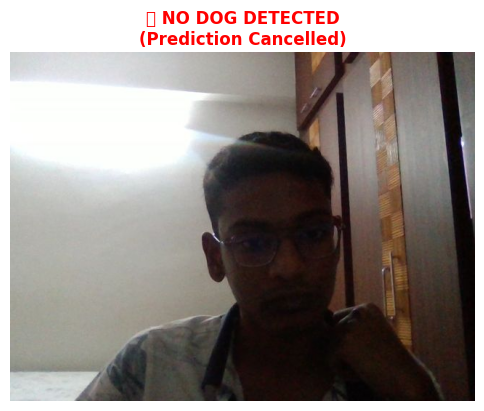

🛑 Analysis stopped because the AI could not find a dog in the frame.


In [6]:
import tensorflow as tf
from tensorflow import keras
import tensorflow_datasets as tfds
import numpy as np
import matplotlib.pyplot as plt
from google.colab import drive, files
from IPython.display import display, Javascript, clear_output
from google.colab.output import eval_js
from base64 import b64decode
import cv2
import os
import shutil
import urllib.request
from datetime import datetime
import sys

# ==========================================
# 1. CONNECT TO DRIVE & VERIFY PATHS
# ==========================================
print("⏳ Step 1: Connecting to Google Drive...")
drive.mount('/content/drive')

# ✅ CORRECT PATH (Inside 'dogclassifier')
MODEL_FOLDER = "/content/drive/MyDrive/Dog_Models_Backup"
HISTORY_FOLDER = "/content/drive/MyDrive/Dog_App_History"

print(f"\n🔍 Step 2: Verifying models in: {MODEL_FOLDER}")

if not os.path.exists(MODEL_FOLDER):
    print(f"❌ ERROR: Cannot find folder at {MODEL_FOLDER}")
    # Fallback check
    if os.path.exists("/content/drive/MyDrive/Dog_Models_Backup"):
        print("⚠️ Found it at root instead! Updating path...")
        MODEL_FOLDER = "/content/drive/MyDrive/Dog_Models_Backup"
    else:
        raise RuntimeError("Stopping: Model Folder missing.")

# Check files
files_found = os.listdir(MODEL_FOLDER)
required = ['resnet50_dogs.keras', 'efficientnetb0_dogs.keras', 'mobilenetv2_dogs.keras', 'mlp_ensemble.keras']
missing = [f for f in required if f not in files_found]
if missing:
    print(f"❌ MISSING FILES: {missing}")
    raise RuntimeError("Missing model files.")

# ==========================================
# 3. LOAD MODELS
# ==========================================
print("\n⏳ Step 3: Loading AI Brains...")
try:
    models = {
        'resnet50': keras.models.load_model(f"{MODEL_FOLDER}/resnet50_dogs.keras"),
        'efficientnetb0': keras.models.load_model(f"{MODEL_FOLDER}/efficientnetb0_dogs.keras"),
        'mobilenetv2': keras.models.load_model(f"{MODEL_FOLDER}/mobilenetv2_dogs.keras")
    }
    mlp = keras.models.load_model(f"{MODEL_FOLDER}/mlp_ensemble.keras")
    print("✅ AI Models Loaded!")
except Exception as e:
    raise RuntimeError(f"Model Load Failed: {e}")

# ==========================================
# 4. SETUP SMART CROP
# ==========================================
print("\n🔄 Step 4: Initializing Smart Crop...")
files_needed = {
    "MobileNetSSD_deploy.prototxt.txt": "https://raw.githubusercontent.com/djmv/MobilNet_SSD_opencv/master/MobileNetSSD_deploy.prototxt",
    "MobileNetSSD_deploy.caffemodel": "https://raw.githubusercontent.com/djmv/MobilNet_SSD_opencv/master/MobileNetSSD_deploy.caffemodel"
}
for fname, url in files_needed.items():
    if not os.path.exists(fname):
        try: urllib.request.urlretrieve(url, fname)
        except: pass
try:
    net = cv2.dnn.readNetFromCaffe("MobileNetSSD_deploy.prototxt.txt", "MobileNetSSD_deploy.caffemodel")
    print("✅ Smart Crop Ready!")
except:
    net = None
    print("⚠️ Smart Crop Disabled")

# ==========================================
# 5. DATA & LOGIC
# ==========================================
cat_breeds = {"Abyssinian","Bengal","Birman","Bombay","British_Shorthair","Egyptian_Mau",
              "Maine_Coon","Persian","Ragdoll","Russian_Blue","Siamese","Sphynx"}
info = tfds.builder("oxford_iiit_pet").info
dog_names = [n for n in info.features["label"].names if n not in cat_breeds]

breed_info = {
    'american_bulldog': {'life': '10-12 yrs', 'traits': 'Confident, Social, Active'},
    'american_pit_bull_terrier': {'life': '8-15 yrs', 'traits': 'Loyal, Courageous, Friendly'},
    'basset_hound': {'life': '12-13 yrs', 'traits': 'Patient, Low-energy, Charming'},
    'beagle': {'life': '10-15 yrs', 'traits': 'Curious, Merry, Friendly'},
    'boxer': {'life': '10-12 yrs', 'traits': 'Bright, Fun-loving, Active'},
    'chihuahua': {'life': '14-16 yrs', 'traits': 'Charming, Graceful, Sassy'},
    'english_cocker_spaniel': {'life': '12-14 yrs', 'traits': 'Merry, Responsive, Gentle'},
    'english_setter': {'life': '12 yrs', 'traits': 'Friendly, Mellow, Merry'},
    'german_shorthaired': {'life': '10-12 yrs', 'traits': 'Friendly, Smart, Willing'},
    'great_pyrenees': {'life': '10-12 yrs', 'traits': 'Smart, Patient, Calm'},
    'havanese': {'life': '14-16 yrs', 'traits': 'Funny, Intelligent, Outgoing'},
    'japanese_chin': {'life': '10-12 yrs', 'traits': 'Charming, Noble, Loving'},
    'keeshond': {'life': '12-15 yrs', 'traits': 'Friendly, Lively, Outgoing'},
    'leonberger': {'life': '7 yrs', 'traits': 'Gentle, Friendly, Playful'},
    'miniature_pinscher': {'life': '12-16 yrs', 'traits': 'Fearless, Spirited, Proud'},
    'newfoundland': {'life': '9-10 yrs', 'traits': 'Sweet, Patient, Devoted'},
    'pomeranian': {'life': '12-16 yrs', 'traits': 'Lively, Bold, Inquisitive'},
    'pug': {'life': '13-15 yrs', 'traits': 'Loving, Charming, Mischievous'},
    'saint_bernard': {'life': '8-10 yrs', 'traits': 'Playful, Charming, Inquisitive'},
    'samoyed': {'life': '12-14 yrs', 'traits': 'Adaptable, Friendly, Gentle'},
    'scottish_terrier': {'life': '12 yrs', 'traits': 'Independent, Confident, Spirited'},
    'shiba_inu': {'life': '13-16 yrs', 'traits': 'Alert, Active, Attentive'},
    'staffordshire_bull_terrier': {'life': '12-14 yrs', 'traits': 'Clever, Brave, Tenacious'},
    'wheaten_terrier': {'life': '12-14 yrs', 'traits': 'Happy, Steady, Confident'},
    'yorkshire_terrier': {'life': '11-15 yrs', 'traits': 'Sprightly, Tomboyish, Loving'}
}

def get_dog_roi(img_path):
    img = cv2.imread(img_path)
    if img is None: return None, False
    if net is None: return cv2.cvtColor(img, cv2.COLOR_BGR2RGB), False
    (h, w) = img.shape[:2]
    blob = cv2.dnn.blobFromImage(cv2.resize(img, (300, 300)), 0.007843, (300, 300), 127.5)
    net.setInput(blob)
    detections = net.forward()
    best_conf = 0.0
    dog_box = None
    for i in range(detections.shape[2]):
        conf = detections[0, 0, i, 2]
        if int(detections[0, 0, i, 1]) == 12 and conf > 0.2:
            if conf > best_conf:
                best_conf = conf
                box = detections[0, 0, i, 3:7] * np.array([w, h, w, h])
                dog_box = box.astype("int")
    if dog_box is not None:
        (sx, sy, ex, ey) = dog_box
        sx, sy = max(0, sx-20), max(0, sy-20)
        ex, ey = min(w, ex+20), min(h, ey+20)
        return cv2.cvtColor(img[sy:ey, sx:ex], cv2.COLOR_BGR2RGB), True
    return cv2.cvtColor(img, cv2.COLOR_BGR2RGB), False

def take_photo(filename='photo.jpg', quality=0.8):
    js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);
      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});
      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);
      await new Promise((resolve) => capture.onclick = resolve);
      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
    display(js)
    data = eval_js('takePhoto({})'.format(quality))
    binary = b64decode(data.split(',')[1])
    with open(filename, 'wb') as f: f.write(binary)
    return filename

def analyze_image(filename, source="upload"):
    print(f"🔍 Analyzing...")

    # 1. Try to find a dog (Smart Crop)
    roi, was_cropped = get_dog_roi(filename)

    # --- PRIVACY: SAVE TO DRIVE (Optional) ---
    if HISTORY_FOLDER:
        ts = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        save_path = f"{HISTORY_FOLDER}/Dog_{source}_{ts}.jpg"
        shutil.copy(filename, save_path)
    # -----------------------------------------

    # 🛑 THE FIX: STRICT STOP IF NO DOG DETECTED
    if not was_cropped:
        # Load the full image just to show the user
        img_display = cv2.imread(filename)
        plt.figure(figsize=(6,6))
        plt.imshow(cv2.cvtColor(img_display, cv2.COLOR_BGR2RGB))

        # Big Red Error Message
        plt.title("🚫 NO DOG DETECTED\n(Prediction Cancelled)", color="red", fontweight="bold")
        plt.axis("off")
        plt.show()

        print("🛑 Analysis stopped because the AI could not find a dog in the frame.")

        # Cleanup and QUIT the function here
        if os.path.exists(filename): os.remove(filename)
        return  # <--- THIS IS THE MAGIC WORD THAT WAS MISSING!

    # 2. If we ARE here, it means we found a dog. Proceed to predict.
    img_r = cv2.resize(roi, (224, 224))
    img_arr = np.expand_dims(img_r, axis=0) / 255.0

    p1 = models['resnet50'].predict(img_arr, verbose=0)
    p2 = models['efficientnetb0'].predict(img_arr, verbose=0)
    p3 = models['mobilenetv2'].predict(img_arr, verbose=0)
    final = mlp.predict(np.concatenate([p1, p2, p3], axis=1), verbose=0)[0]

    # Top 3 Logic
    top_3 = np.argsort(final)[-3:][::-1]
    top_name = dog_names[top_3[0]]
    top_conf = final[top_3[0]] * 100
    info = breed_info.get(top_name, {'life': '?', 'traits': '?'})

    plt.figure(figsize=(6,6))
    plt.imshow(roi)
    # Removed the trophy emoji 🏆 because it was causing that "Glyph missing" warning in your screenshot
    plt.title(f"MATCH: {top_name} ({top_conf:.1f}%)\n{info['life']}", color="green", fontweight="bold")
    plt.axis("off")
    plt.show()

    print(f"\n📊 TOP 3 PREDICTIONS:")
    for i in top_3:
        print(f"• {dog_names[i]}: {final[i]*100:.1f}%")

    if os.path.exists(filename): os.remove(filename)

    # Privacy Save
    if HISTORY_FOLDER:
        if not os.path.exists(HISTORY_FOLDER): os.makedirs(HISTORY_FOLDER)
        ts = datetime.now().strftime("%Y-%m-%d_%H-%M-%S")
        save_path = os.path.join(HISTORY_FOLDER, f"Dog_{source_type}_{ts}.jpg")
        shutil.copy(filename, save_path)
        print(f"💾 Saved to Drive: {save_path}")

    if not was_cropped:
        print("⚠️ No dog detected (Showing full image)")

    # 1. Get Base Predictions
    img_r = cv2.resize(roi_img, (224, 224))
    img_arr = np.expand_dims(img_r, axis=0) / 255.0

    p1 = models['resnet50'].predict(img_arr, verbose=0)
    p2 = models['efficientnetb0'].predict(img_arr, verbose=0)
    p3 = models['mobilenetv2'].predict(img_arr, verbose=0)

    # 2. Get Meta-Learner Prediction
    final_probs = mlp.predict(np.concatenate([p1, p2, p3], axis=1), verbose=0)[0]
    mlp_conf = np.max(final_probs)

    # 3. WEIGHTED VOTING LOGIC (Fallback)
    if mlp_conf < 0.50:
        print(f"⚠️ Low Confidence ({mlp_conf*100:.1f}%). Switching to Weighted Voting...")
        # Weights: EfficientNetB0(0.5), ResNet50(0.3), MobileNetV2(0.2)
        final_probs = (p2[0] * 0.5) + (p1[0] * 0.3) + (p3[0] * 0.2)

    # 4. Final Processing
    final_conf = np.max(final_probs) * 100
    top_3 = np.argsort(final_probs)[-3:][::-1]
    top_name = dog_names[top_3[0]]
    info = breed_info.get(top_name, {'life': '?', 'traits': '?'})

    # 5. Display
    plt.figure(figsize=(6,6))
    plt.imshow(roi_img)

    # UNCERTAIN FEATURE ALERT
    if final_conf < 50:
        # Show Traits even if uncertain
        title = f"⚠️ Uncertain ({final_conf:.1f}%)\nBest Guess: {top_name}\nTraits: {info['traits']}"
        color = "red"
        print(f"\n⚠️ ALERT: Prediction Confidence is low (<50%). Results may be inaccurate.")
    else:
        # Show Life AND Traits
        title = f"🏆 {top_name} ({final_conf:.1f}%)\nLife: {info['life']}\nTraits: {info['traits']}"
        color = "green"

    plt.title(title, color=color, fontweight="bold", fontsize=10)
    plt.axis("off")
    plt.show()

    # Explicit Print for clarity
    print(f"\n🐶 Breed Match: {top_name}")
    print(f"⏳ Lifespan:    {info['life']}")
    print(f"🧠 Traits:      {info['traits']}")

    print(f"\n📊 TOP 3 BREAKDOWN:")
    for i in top_3:
        print(f"• {dog_names[i]}: {final_probs[i]*100:.1f}%")

    if os.path.exists(filename): os.remove(filename)

# ==========================================
# 6. RUN MENU
# ==========================================
def run_app():
    print("\n🐶 DOG CLASSIFIER MENU")
    print("1️⃣. Use Camera")
    print("2️⃣. Upload File")
    c = input("👉 Enter 1 or 2: ")
    if c == '1':
        fname = take_photo('temp_cam.jpg')
        if fname: analyze_image(fname, "cam")
    elif c == '2':
        uploaded = files.upload()
        for f in uploaded.keys():
            analyze_image(f, "upload")
    else:
        print("❌ Invalid.")

run_app()